In [49]:
import numpy as np
import os
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, models, layers
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
import torchvision.models as models
from sklearn.manifold import TSNE
from keras.layers import concatenate, Dense, Input
from tensorflow.keras.layers import BatchNormalization, Activation

In [ ]:
stemming_val = 128
LABELS = ['T-shirt/top','Trouser','Pullover','Dress',  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'] 

Load and split DS

In [17]:
from sklearn.model_selection import train_test_split
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


Normalization

In [40]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.

print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)

X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [41]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [42]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

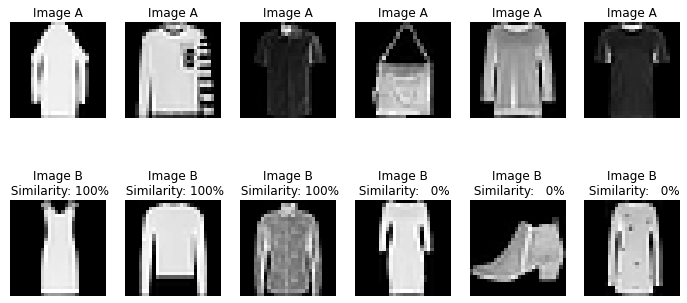

In [52]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0], cmap='gray')
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0], cmap='gray')
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [47]:
def conv2D_bn_relu(x, filters, kernel_size, strides, padding='valid', kernel_initializer='glorot_uniform', name=None):

    x = layers.Conv2D(filters=filters, 
                      kernel_size=kernel_size, 
                      strides=strides, 
                      padding=padding, 
                      kernel_initializer=kernel_initializer,
                      name=name,
                      use_bias=False)(x)
    x = layers.BatchNormalization(scale=False)(x)
    return layers.Activation('relu')(x)


In [ ]:
def inception_module_A(x, filters=None, kernel_initializer='glorot_uniform'):
    
    if filters is None:
        filters = int(x.shape[-1])
    branch_filters = filters // 4
        
    branch_1 = conv2D_bn_relu(x, 
                        filters=(branch_filters // 3) * 2, 
                        kernel_size=1, 
                        strides=1, 
                        kernel_initializer=kernel_initializer)
    branch_1 = conv2D_bn_relu(branch_1, 
                        filters=branch_filters, 
                        kernel_size=3, 
                        strides=1, 
                        padding='same', 
                        kernel_initializer=kernel_initializer)
    
    branch_2 = conv2D_bn_relu(x, 
                        filters=(branch_filters // 3) * 2, 
                        kernel_size=1, 
                        strides=1, 
                        kernel_initializer=kernel_initializer)
    branch_2 = conv2D_bn_relu(branch_2, 
                        filters=branch_filters, 
                        kernel_size=3, 
                        strides=1, 
                        padding='same', 
                        kernel_initializer=kernel_initializer)
    branch_2 = conv2D_bn_relu(branch_2, 
                        filters=branch_filters, 
                        kernel_size=3, 
                        strides=1, 
                        padding='same', 
                        kernel_initializer=kernel_initializer)
        
    branch_3 = conv2D_bn_relu(x, 
                        filters=branch_filters, 
                        kernel_size=1, 
                        strides=1, 
                        kernel_initializer=kernel_initializer)
    
    pool = layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    pool = conv2D_bn_relu(pool, 
                          filters=branch_filters, 
                          kernel_size=1, 
                          strides=1, 
                          kernel_initializer=kernel_initializer)

    return layers.concatenate([branch_1, branch_2, branch_3, pool])

In [ ]:
def reduction_module_A(x, filters, kernel_initializer='glorot_uniform'):

    branch_filters = (filters - int(x.shape[-1])) // 2
        
    branch_1 = conv2D_bn_relu(x, 
                        filters=branch_filters, 
                        kernel_size=3, 
                        strides=2, 
                        padding='same', 
                        kernel_initializer=kernel_initializer)
    
    branch_2 = conv2D_bn_relu(x, 
                        filters=(branch_filters // 3) * 2, 
                        kernel_size=1, 
                        strides=1, 
                        kernel_initializer=kernel_initializer)
    branch_2 = conv2D_bn_relu(branch_2, 
                        filters=(branch_filters // 6) * 5, 
                        kernel_size=3, 
                        strides=1, 
                        padding='same', 
                        kernel_initializer=kernel_initializer)
    branch_2 = conv2D_bn_relu(branch_2, 
                        filters=branch_filters, 
                        kernel_size=3, 
                        strides=2, 
                        padding='same', 
                        kernel_initializer=kernel_initializer)
    
    pool = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    return layers.concatenate([branch_1, branch_2, pool])

In [ ]:
def inception_module_C(x, filters=None, kernel_initializer='glorot_uniform'):  
    if filters is None:
        filters = int(x.shape[-1])
    branch_filters = filters // 6
        
    branch_1 = conv2D_bn_relu(x, 
                        filters=(branch_filters // 2) * 3, 
                        kernel_size=1, 
                        strides=1, 
                        kernel_initializer=kernel_initializer)
        
    branch_1 = conv2D_bn_relu(branch_1, 
                         filters=branch_filters, 
                         kernel_size=(1, 3), 
                         strides=1, 
                         padding='same', 
                         kernel_initializer=kernel_initializer)
    
    branch_1 = conv2D_bn_relu(branch_1, 
                         filters=branch_filters, 
                         kernel_size=(3, 1), 
                         strides=1, 
                         padding='same', 
                         kernel_initializer=kernel_initializer)
    
    branch_2 = conv2D_bn_relu(x, 
                        filters=(branch_filters // 2) * 3, 
                        kernel_size=1, 
                        strides=1, 
                        kernel_initializer=kernel_initializer)
    branch_2 = conv2D_bn_relu(branch_2, 
                        filters=(branch_filters // 4) * 7, 
                        kernel_size=(1, 3), 
                        strides=1, 
                        padding='same', 
                        kernel_initializer=kernel_initializer)
    branch_2 = conv2D_bn_relu(branch_2, 
                        filters=branch_filters * 2, 
                        kernel_size=(3, 1), 
                        strides=1, 
                        padding='same', 
                        kernel_initializer=kernel_initializer)

    branch_2 = conv2D_bn_relu(branch_2, 
                         filters=branch_filters, 
                         kernel_size=(1, 3), 
                         strides=1, 
                         padding='same', 
                         kernel_initializer=kernel_initializer)
    
    branch_2 = conv2D_bn_relu(branch_2, 
                         branch_filters, 
                         kernel_size=(3, 1), 
                         strides=1, 
                         padding='same', 
                         kernel_initializer=kernel_initializer)
        
    branch_3 = conv2D_bn_relu(x, 
                        filters=branch_filters, 
                        kernel_size=1, 
                        strides=1, 
                        kernel_initializer=kernel_initializer)
    
    pool = layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    pool = conv2D_bn_relu(pool, 
                          filters=branch_filters, 
                          kernel_size=1, 
                          strides=1, 
                          kernel_initializer=kernel_initializer)
    
    return layers.concatenate([branch_1, branch_2, branch_3, pool])

In [50]:
inputs = layers.Input(shape=x_train.shape[1:])

x = conv2D_bn_relu(inputs, filters=stemming_val, kernel_size=5, strides=1, padding='same', name='conv_1')
x = reduction_module_A(x, filters=int(2*stemming_val))
x = layers.SpatialDropout2D(0.3)(x)
x = inception_module_A(x, filters=int(2*stemming_val))
x = inception_module_A(x, filters=int(2*stemming_val))
x = reduction_module_A(x, filters=int(3*stemming_val))
x = layers.SpatialDropout2D(0.5)(x)
x = inception_module_C(x, filters=int(3*stemming_val))
x = inception_module_C(x, filters=int(3*stemming_val))
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32)(x)

model = keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 28, 28, 128)  3200        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_43 (BatchN  (None, 28, 28, 128)  384        ['conv_1[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 activation_43 (Activation)     (None, 28, 28, 128)  0           ['batch_normalization_43[0][0

In [53]:
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

combined_features = concatenate([img_a_feat, img_b_feat], name =
'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = keras.Model(inputs = [img_a_in, img_b_in], outputs =
[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 32)           1204616     ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['model[0][0]',   

In [54]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

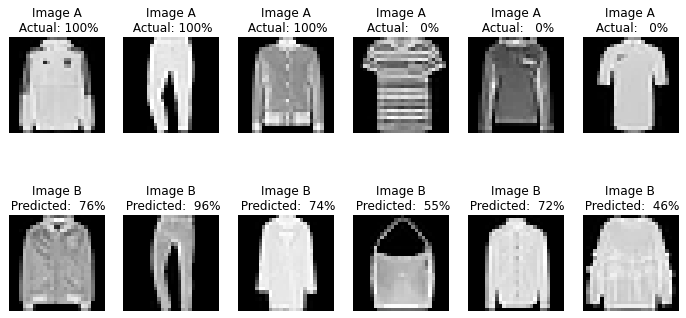

In [59]:
def show_model_output(nb_examples = 3):
  pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
  pred_sim = similarity_model.predict([pv_a, pv_b])
  fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
  for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0], cmap='gray')
    ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0], cmap='gray')
    ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
    ax2.axis('off')
  return fig
  #completely untrained model
_ = show_model_output()

In [57]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
  while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups), steps_per_epoch = 250, validation_data=([valid_a, valid_b], valid_sim), epochs = 10, verbose = True)

Epoch 1/10
250/250 [==============================] - 620s 2s/step - loss: 0.6779 - mae: 0.4865 - val_loss: 1.0427 - val_mae: 0.4970
Epoch 2/10
250/250 [==============================] - 633s 3s/step - loss: 0.5771 - mae: 0.4128 - val_loss: 6.2643 - val_mae: 0.5000
Epoch 3/10
250/250 [==============================] - 629s 3s/step - loss: 0.5044 - mae: 0.3548 - val_loss: 0.6018 - val_mae: 0.3672
Epoch 4/10
250/250 [==============================] - 630s 3s/step - loss: 0.4499 - mae: 0.3110 - val_loss: 0.9958 - val_mae: 0.4997
Epoch 5/10
250/250 [==============================] - 630s 3s/step - loss: 0.4462 - mae: 0.2992 - val_loss: 0.4284 - val_mae: 0.2721
Epoch 6/10
250/250 [==============================] - 635s 3s/step - loss: 0.4242 - mae: 0.2850 - val_loss: 0.4227 - val_mae: 0.2665
Epoch 7/10
250/250 [==============================] - 636s 3s/step - loss: 0.4224 - mae: 0.2808 - val_loss: 0.6299 - val_mae: 0.3531
Epoch 8/10
250/250 [==============================] - 636s 3s/step - 

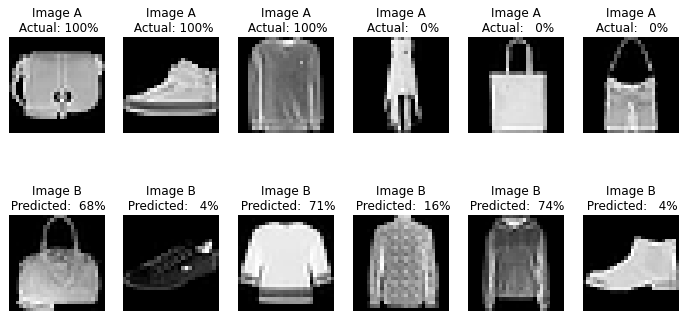

In [60]:
_ = show_model_output()

In [61]:
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

79/79 [==============================] - 68s 857ms/step


In [62]:
tsne_obj = TSNE(n_components=2,init='pca',random_state=101, method='barnes_hut',n_iter=500,verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.806s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.389709
[t-SNE] Computed conditional probabilities in 0.499s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 63.9483643, gradient norm = 0.0023826 (50 iterations in 18.648s)
[t-SNE] Iteration 100: error = 64.3802948, gradient norm = 0.0016604 (50 iterations in 6.579s)
[t-SNE] Iteration 150: error = 64.6094055, gradient norm = 0.0018675 (50 iterations in 6.558s)
[t-SNE] Iteration 200: error = 64.8347321, gradient norm = 0.0008669 (50 iterations in 6.774s)
[t-SNE] Iteration 250: error = 65.0024567, gradient norm = 0.0007821 (50 iterations in 6.891s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.002457
[t-SNE] Iteration 300: error = 2.0984247, gradient norm = 0.0009735 (50 iterations in 6.684s)
[t-SNE] Iteration 350: error = 1.7713406, gradient norm = 0.0005350 (50 iterations in 5.911s)
[t-SNE] Iteration 400: error = 1.5663325, gradient norm = 0.0003565 (50 iterations in 5.246s)
[t-SNE] Iteration 450: error = 1.4233177, gradient norm = 0.0002621 (50 iterations in 4.900s)
[t-SNE] Iteration 500: error = 1.3213444, gradient norm = 0.0001953 (50

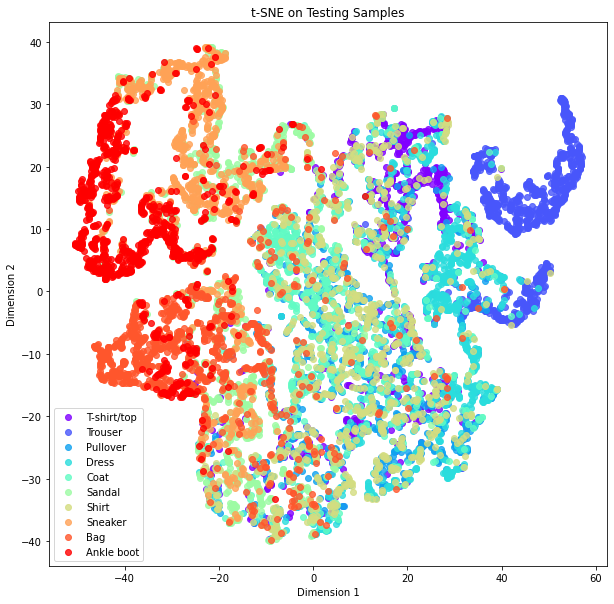

In [63]:
colors = plt.cm.rainbow(np.linspace(0, 1, 10)) 
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, LABELS)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],  tsne_features[np.where(y_test == c_group), 1],  marker='o', color=c_color, linewidth=1, alpha=0.8, label=c_label) 
plt.xlabel('Dimension 1') 
plt.ylabel('Dimension 2') 
plt.title('t-SNE on Testing Samples') 
plt.legend(loc='best')  
plt.show(block=False)

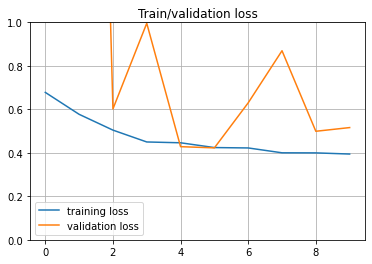

In [64]:
def plot_history(history):
    plt.title('Train/validation loss')
    plt.plot(history.history['loss'], label = 'training loss')
    plt.plot(history.history['val_loss'], label = 'validation loss')
    plt.grid()
    plt.legend()
    plt.ylim(0,1)
    plt.show()

plot_history(loss_history)